In [1]:
!pip install pandas matplotlib openpyxl

In [22]:
import pandas as pd
import jdatetime

# Load your Excel file
df = pd.read_excel("pizometer_data.xlsx", sheet_name = 'کلاته کریم خان' )

bad_dates = []

def shamsi_to_gregorian(date_str):
    try:
        year, month, day = map(int, date_str.split('/'))
        return jdatetime.date(year, month, day).togregorian()
    except ValueError as e:
        bad_dates.append((date_str, str(e)))
        return None  # Return None for problematic entries

df['gregorian_date'] = df['tarikh'].apply(shamsi_to_gregorian)

# Show invalid dates
print("Bad dates found:")
for d in bad_dates:
    print(d)


Bad dates found:
('1387/5/0', 'day is out of range for month')
('1387/6/0', 'day is out of range for month')


In [23]:
df = df.dropna(subset=['gregorian_date'])


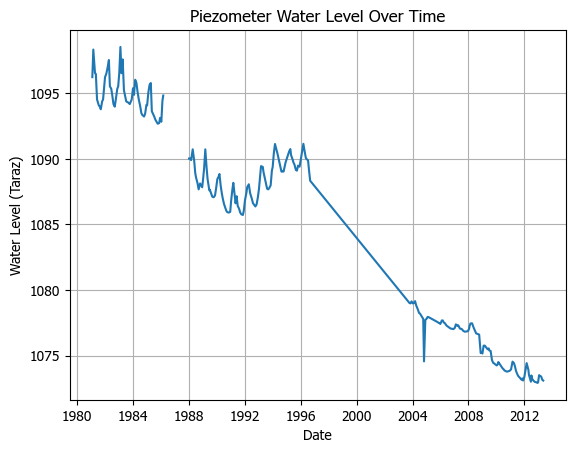

In [24]:
import matplotlib.pyplot as plt

df = df.sort_values('gregorian_date')
plt.plot(df['gregorian_date'], df['taraz'])
plt.xlabel('Date')
plt.ylabel('Water Level (Taraz)')
plt.title('Piezometer Water Level Over Time')
plt.grid(True)
plt.show()


In [26]:
import pandas as pd
import jdatetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

# Use a font that supports Persian
rcParams['font.family'] = 'Tahoma'  # Change to 'B Nazanin', 'Vazir', etc., if needed
plt.rcParams['axes.unicode_minus'] = False

# Load the Excel file
excel_path = "pizometer_data.xlsx"
sheets = pd.read_excel(excel_path, sheet_name=None)  # Load all sheets

# Output folder for plots
os.makedirs("plots", exist_ok=True)

# Function to convert Shamsi to Gregorian
def shamsi_to_gregorian_safe(date_str):
    try:
        year, month, day = map(int, str(date_str).split('/'))
        return jdatetime.date(year, month, day).togregorian()
    except:
        return None

# Process each sheet
for sheet_name, df in sheets.items():
    # Skip if required columns are missing
    if 'tarikh' not in df.columns or 'taraz' not in df.columns:
        continue

    # Convert dates
    df['tarikh_miladi'] = df['tarikh'].apply(shamsi_to_gregorian_safe)
    df = df.dropna(subset=['tarikh_miladi'])

    # Sort and plot
    df = df.sort_values('tarikh_miladi')
    plt.figure(figsize=(10, 4))
    plt.plot(df['tarikh_miladi'], df['taraz'], marker='o', linestyle='-', color='blue')
    plt.xlabel('تاریخ میلادی')
    plt.ylabel('تراز (متر)')
    plt.title(sheet_name)
    plt.grid(True)

    # Save plot
    safe_name = "".join(c if c.isalnum() else "_" for c in sheet_name)
    plt.savefig(f"plots/{safe_name}.png", bbox_inches='tight', dpi=300)
    plt.close()

    # Optional: update the sheet in memory if you want to write back to Excel later
    sheets[sheet_name] = df

print("✅ All sheets processed and plots saved in 'plots/' folder.")


✅ All sheets processed and plots saved in 'plots/' folder.


In [30]:
import pandas as pd
import jdatetime
import matplotlib.pyplot as plt
import os

# Load the Excel file
excel_path = "pizometer_data.xlsx"  # Update with your actual file name
sheets = pd.read_excel(excel_path, sheet_name=None)  # Load all sheets

# Create folder for output plots
os.makedirs("plots", exist_ok=True)

# Function to convert Shamsi date to Gregorian safely
def shamsi_to_gregorian_safe(date_str):
    try:
        year, month, day = map(int, str(date_str).split('/'))
        return jdatetime.date(year, month, day).togregorian()
    except:
        return None

# Process each sheet
for sheet_name, df in sheets.items():
    # Skip if columns missing
    if 'tarikh' not in df.columns or 'taraz' not in df.columns:
        continue

    # Convert dates
    df['tarikh_miladi'] = df['tarikh'].apply(shamsi_to_gregorian_safe)
    df = df.dropna(subset=['tarikh_miladi'])

    # Sort and plot
    df = df.sort_values('tarikh_miladi')
    plt.figure(figsize=(10, 4))
    plt.plot(df['tarikh_miladi'], df['taraz'], marker='o', linestyle='-', color='blue')
    plt.xlabel('Gregorian Date')
    plt.ylabel('Taraz (m)')
    plt.title("piezometer observation")
    plt.grid(True)

    # Save plot with sheet name (supports Persian)
    plt.savefig(f"plots/{sheet_name}.png", bbox_inches='tight', dpi=300)
    plt.close()

    # Update sheet data
    sheets[sheet_name] = df

print("✅ All sheets processed. Plots saved in 'plots/' folder.")


✅ All sheets processed. Plots saved in 'plots/' folder.


In [33]:
import pandas as pd
import jdatetime
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import numpy as np

# Load the Excel file
excel_path = "pizometer_data.xlsx"
sheets = pd.read_excel(excel_path, sheet_name=None)

# Create folder for plots
os.makedirs("plots", exist_ok=True)

def shamsi_to_gregorian_safe(date_str):
    try:
        year, month, day = map(int, str(date_str).split('/'))
        return jdatetime.date(year, month, day).togregorian()
    except:
        return None

for sheet_name, df in sheets.items():
    if 'tarikh' not in df.columns or 'taraz' not in df.columns:
        print(f"⛔ Skipping '{sheet_name}': Missing 'tarikh' or 'taraz'")
        continue

    df['tarikh_miladi'] = df['tarikh'].apply(shamsi_to_gregorian_safe)
    df = df.dropna(subset=['tarikh_miladi', 'taraz'])

    # Make sure 'taraz' is numeric
    df['taraz'] = pd.to_numeric(df['taraz'], errors='coerce')
    df = df.dropna(subset=['taraz'])

    if len(df) < 2:
        print(f"⚠️ Not enough data in '{sheet_name}' for plotting.")
        continue

    df = df.sort_values('tarikh_miladi')

    x = mdates.date2num(df['tarikh_miladi'])
    y = df['taraz'].values

    # Plot
    plt.figure(figsize=(14, 4))
    plt.scatter(df['tarikh_miladi'], df['taraz'], color='blue', label='Observations')

    # Fit regression only if values are not constant
    if len(x) >= 2 and np.std(y) > 1e-6:
        try:
            coeffs = np.polyfit(x, y, 1)
            trendline = np.poly1d(coeffs)
            y_trend = trendline(x)
            plt.plot(df['tarikh_miladi'], y_trend, color='red', linestyle='--', label='Trendline')
        except np.linalg.LinAlgError:
            print(f"⚠️ Trendline failed for '{sheet_name}' (SVD issue)")

    plt.xlabel('Gregorian Date')
    plt.ylabel('Taraz (m)')
    plt.title("piezometer observation")
    plt.legend()
    plt.grid(True)

    # Save plot
    plt.savefig(f"plots/{sheet_name}.png", bbox_inches='tight', dpi=300)
    plt.close()

    sheets[sheet_name] = df

print("✅ All plots saved successfully in 'plots/' folder.")


C:\Users\acer\AppData\Local\Temp\ipykernel_12772\2474425089.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['taraz'] = pd.to_numeric(df['taraz'], errors='coerce')
C:\Users\acer\AppData\Local\Temp\ipykernel_12772\2474425089.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['taraz'] = pd.to_numeric(df['taraz'], errors='coerce')
C:\Users\acer\AppData\Local\Temp\ipykernel_12772\2474425089.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

✅ All plots saved successfully in 'plots/' folder.


In [35]:
import pandas as pd
import jdatetime
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import numpy as np

# Load the Excel file
excel_path = "pizometer_data.xlsx"  # Update with your actual file name
sheets = pd.read_excel(excel_path, sheet_name=None)

# Create folder for plots
os.makedirs("subsidence_plots", exist_ok=True)

# Function to convert Shamsi to Gregorian safely
def shamsi_to_gregorian_safe(date_str):
    try:
        year, month, day = map(int, str(date_str).split('/'))
        return jdatetime.date(year, month, day).togregorian()
    except:
        return None

# Process each sheet
for sheet_name, df in sheets.items():
    if 'date' not in df.columns or 'subsidence' not in df.columns:
        continue

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date', 'subsidence'])

    # Sort by date
    df = df.sort_values('date')

    # Convert to matplotlib date format
    x = mdates.date2num(df['date'])
    y = df['subsidence'].astype(float).values

    # Fit trendline
    if len(x) >= 2:
        coeffs = np.polyfit(x, y, 1)
        trendline = np.poly1d(coeffs)
        y_trend = trendline(x)

    # Plot
    plt.figure(figsize=(14, 4))
    plt.scatter(df['date'], y, color='indianred', label='Subsidence Observations')
    if len(x) >= 2:
        plt.plot(df['date'], y_trend, color='black', linestyle='--', label='Trendline')

    plt.xlabel('Gregorian Date')
    plt.ylabel('Subsidence (mm)')
    plt.title("piezometer observation")
    plt.legend()
    plt.grid(True)

    # Save plot
    plt.savefig(f"subsidence_plots/{sheet_name}.png", bbox_inches='tight', dpi=300)
    plt.close()

print("✅ Subsidence scatter plots saved in 'subsidence_plots/' folder.")


✅ Subsidence scatter plots saved in 'subsidence_plots/' folder.


In [38]:
import pandas as pd
import jdatetime
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import numpy as np

# Load the Excel file
excel_path = "pizometer_data.xlsx"  # Update with your actual file name
sheets = pd.read_excel(excel_path, sheet_name=None)

output_dir = "subsidence_plots"
os.makedirs(output_dir, exist_ok=True)

# Function to strip whitespace from column names
def clean_columns(df):
    df.columns = df.columns.str.strip()  # Strip leading/trailing whitespace
    return df

# Process each sheet
for sheet_name, df in sheets.items():
    print(f"📄 Processing sheet: {sheet_name}")
    
    # Clean column names
    df = clean_columns(df)

    print(f"Columns: {df.columns}")

    if 'date' not in df.columns or 'subsidence' not in df.columns:
        print(f"⚠️ Skipped '{sheet_name}': Missing required columns.")
        continue

    # Convert date to datetime and check
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print(f"First few date values after conversion: {df['date'].head()}")

    df = df.dropna(subset=['date', 'subsidence'])

    if df.empty:
        print(f"⚠️ Skipped '{sheet_name}': No valid data after cleaning.")
        continue

    print(f"First few rows of cleaned data:\n{df.head()}")

    df = df.sort_values('date')
    x = mdates.date2num(df['date'])
    y = df['subsidence'].astype(float).values

    if len(x) >= 2:
        coeffs = np.polyfit(x, y, 1)
        trendline = np.poly1d(coeffs)
        y_trend = trendline(x)

    plt.figure(figsize=(14, 4))
    plt.scatter(df['date'], y, color='indianred', label='Subsidence Observations')
    if len(x) >= 2:
        plt.plot(df['date'], y_trend, color='black', linestyle='--', label='Trendline')

    plt.xlabel('Gregorian Date')
    plt.ylabel('Subsidence (mm)')
    plt.title("InSAR observation")
    plt.legend()
    plt.grid(True)

    # Save the plot
    safe_name = sheet_name.strip()  # Ensure sheet name is clean and safe
    plt.savefig(f"{output_dir}/{safe_name}.png", bbox_inches='tight', dpi=300)
    plt.close()

print("✅ Subsidence plots saved in 'subsidence_plots/' folder.")


📄 Processing sheet: بی نام
Columns: Index(['سال', 'ماه', 'روز', 'سال_آ', 'کد_مح', 'محدود', 'نام_م', 'سطح_آ',
       'XUTM', 'YUTM', 'علت_ع', 'تراز__', 'ملاحظ', 'تيسن__', 'تيسن_1', 'taraz',
       'tarikh', 'date', 'subsidence'],
      dtype='object')
First few date values after conversion: 0   2015-02-20
1   2015-03-04
2   2015-03-28
3   2015-04-21
4   2015-05-15
Name: date, dtype: datetime64[ns]
First few rows of cleaned data:
    سال  ماه  روز    سال_آ  کد_مح          محدود نام_م  سطح_آ    XUTM  \
0  1375    7   29  1375-76   6007  مشهد - چناران        35.69  684800   
1  1375    8   29  1375-76   6007  مشهد - چناران        36.31  684800   
2  1375    9   20  1375-76   6007  مشهد - چناران        36.36  684800   
3  1375   10    3  1375-76   6007  مشهد - چناران        36.55  684800   
4  1375   12   20  1375-76   6007  مشهد - چناران        37.33  684800   

      YUTM  علت_ع  تراز__  ملاحظ  تيسن__  تيسن_1  taraz      tarikh  \
0  4054000      0       0      0       0       0 -35.69   

In [7]:
import pandas as pd
import jdatetime
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

# Load the Excel file
excel_path = "pizometer_data.xlsx"
sheets = pd.read_excel(excel_path, sheet_name=None)

# Output folder
os.makedirs("combined_plots", exist_ok=True)

# Convert Shamsi to Gregorian
def shamsi_to_gregorian_safe(date_str):
    try:
        year, month, day = map(int, str(date_str).split('/'))
        return jdatetime.date(year, month, day).togregorian()
    except:
        return None

# Plot each sheet
for sheet_name, df in sheets.items():
    print(f"📄 Processing sheet: {sheet_name}")

    has_pizo = 'tarikh' in df.columns and 'taraz' in df.columns
    has_subsidence = 'date' in df.columns and 'subsidence' in df.columns

    if not (has_pizo and has_subsidence):
        print(f"⚠️ Skipped '{sheet_name}': Missing required columns.")
        continue

    # Prepare piezometer data
    pizo = df[['tarikh', 'taraz']].copy()
    pizo['tarikh_miladi'] = pizo['tarikh'].apply(shamsi_to_gregorian_safe)
    pizo = pizo.dropna(subset=['tarikh_miladi'])
    pizo = pizo.sort_values('tarikh_miladi')

    # Prepare subsidence data
    sub_data = df[['date', 'subsidence']].copy()
    sub_data['date'] = pd.to_datetime(sub_data['date'], errors='coerce')
    sub_data = sub_data.dropna(subset=['date'])
    sub_data = sub_data.sort_values('date')

    # Align x-axis numerically for trendlines
    x1 = pizo['tarikh_miladi']
    y1 = pizo['taraz']
    x2 = sub_data['date']
    y2 = sub_data['subsidence']

    x1_numeric = (x1 - x1.min()).dt.days
    x2_numeric = (x2 - x2.min()).dt.days

    # Set style
    sns.set_style("darkgrid", {'grid.linestyle': ''})
    fig, ax1 = plt.subplots(figsize=(14, 4))

    # Piezometer scatter
    sns.scatterplot(x=x1, y=y1, marker='o', s=50, color='royalblue', ax=ax1)
    ax1.set_ylabel('Water Level (Meter)')
    ax1.set_xlabel('Date')

    if len(x1_numeric) >= 2:
        z1 = np.polyfit(x1_numeric, y1, 1)
        p1 = np.poly1d(z1)
        ax1.plot(x1, p1(x1_numeric), linestyle='--', color='royalblue', label='Trendline (Water Level)', linewidth=4)

    # Subsidence scatter
    ax2 = ax1.twinx()
    sns.scatterplot(x=x2, y=y2, marker='s', s=25, color='indianred', label='Subsidence', ax=ax2)
    ax2.set_ylabel('Subsidence (mm)')
    ax2.get_yaxis().set_label_coords(1.12, 0.5)

    if len(x2_numeric) >= 2:
        z2 = np.polyfit(x2_numeric, y2, 1)
        p2 = np.poly1d(z2)
        ax2.plot(x2, p2(x2_numeric), linestyle='--', color='indianred', label='Trendline (Subsidence)', linewidth=4)

    # Add flood event vertical lines
    flood_start = pd.to_datetime('2019-01-10')
    flood_end = pd.to_datetime('2019-05-10')
    ax1.axvline(x=flood_start, color='gray', linestyle='--', label='97 flood')
    ax1.axvline(x=flood_end, color='gray', linestyle='--')

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    combined = dict(zip(labels1 + labels2, handles1 + handles2))
    ax1.legend(combined.values(), combined.keys(), loc='best')

    plt.title('Piezometer and Subsidence')
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"combined_plots/{sheet_name}.png", dpi=300)
    plt.close()
    print(f"✅ Saved combined plot for '{sheet_name}'.")

print("🎉 All combined plots saved in 'combined_plots/' folder.")


📄 Processing sheet: بی نام


AttributeError: Can only use .dt accessor with datetimelike values

In [4]:
print(f"📄 Processing sheet: {sheet_name}")
print("Columns found:", df.columns.tolist())


📄 Processing sheet: آبقد
Columns found: ['سال', 'ماه', 'روز', 'سال_آ', 'کد_مح', 'محدود', 'نام_م', 'سطح_آ', 'XUTM', 'YUTM', 'علت_ع', 'تراز__', 'ملاحظ', 'تيسن__', 'تيسن_1', 'taraz', 'tarikh', 'date', 'subsidence ']


In [5]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower()


In [6]:
if not {'tarikh', 'taraz', 'date', 'subsidence'}.issubset(df.columns):
    print(f"⚠️ Skipped '{sheet_name}': Missing required columns.")
    continue


SyntaxError: 'continue' not properly in loop (4056932298.py, line 3)

In [16]:
import pandas as pd
import jdatetime
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

# Load the Excel file
excel_path = "pizometer_data.xlsx"
sheets = pd.read_excel(excel_path, sheet_name=None)

# Output folder
os.makedirs("combined_plots", exist_ok=True)

# Convert Shamsi to Gregorian
def shamsi_to_gregorian_safe(date_str):
    try:
        year, month, day = map(int, str(date_str).split('/'))
        return jdatetime.date(year, month, day).togregorian()
    except:
        return None

# Plot each sheet
for sheet_name, df in sheets.items():
    print(f"\n📄 Processing sheet: {sheet_name}")

    has_pizo = 'tarikh' in df.columns and 'taraz' in df.columns
    has_subsidence = 'date' in df.columns and 'subsidence' in df.columns

    if not (has_pizo and has_subsidence):
        print(f"⚠️ Skipped '{sheet_name}': Missing required columns.")
        continue

    # Prepare piezometer data
    pizo = df[['tarikh', 'taraz']].copy()
    pizo['tarikh_miladi'] = pizo['tarikh'].apply(shamsi_to_gregorian_safe)
    pizo['tarikh_miladi'] = pd.to_datetime(pizo['tarikh_miladi'], errors='coerce')  # ✅ Ensure datetime format
    pizo = pizo.dropna(subset=['tarikh_miladi'])
    pizo = pizo.sort_values('tarikh_miladi')

    # Prepare subsidence data
    sub_data = df[['date', 'subsidence']].copy()
    sub_data['date'] = pd.to_datetime(sub_data['date'], errors='coerce')
    sub_data = sub_data.dropna(subset=['date'])
    sub_data = sub_data.sort_values('date')

    # Align x-axis numerically for trendlines
    x1 = pizo['tarikh_miladi']
    y1 = pizo['taraz']
    x2 = sub_data['date']
    y2 = sub_data['subsidence']

    try:
        x1_numeric = (x1 - x1.min()).dt.days
    except Exception as e:
        print(f"⚠️ Skipped '{sheet_name}': x1 conversion failed: {e}")
        continue

    try:
        x2_numeric = (x2 - x2.min()).dt.days
    except Exception as e:
        print(f"⚠️ Skipped '{sheet_name}': x2 conversion failed: {e}")
        continue

    # Set style
    sns.set_style("darkgrid", {'grid.linestyle': ''})
    fig, ax1 = plt.subplots(figsize=(14, 4))

    # Piezometer scatter
    sns.scatterplot(x=x1, y=y1, marker='o', s=50, color='royalblue', ax=ax1)
    ax1.set_ylabel('Water Level (Meter)')
    ax1.set_xlabel('Date')

    if len(x1_numeric) >= 2:
        try:
            valid_idx = (~x1_numeric.isna()) & (~y1.isna())
            x1_clean = x1_numeric[valid_idx]
            y1_clean = y1[valid_idx]
            if len(x1_clean) >= 2:
                z1 = np.polyfit(x1_clean, y1_clean, 1)
                p1 = np.poly1d(z1)
                ax1.plot(x1[valid_idx], p1(x1_clean), linestyle='--', color='royalblue',
                         label='Water Level', linewidth=2)
        except Exception as e:
            print(f"⚠️ Trendline for Water Level failed in '{sheet_name}': {e}")

    # Subsidence scatter
    ax2 = ax1.twinx()
    sns.scatterplot(x=x2, y=y2, marker='s', s=25, color='indianred' ,ax=ax2 ) #, label='Subsidence'
    ax2.set_ylabel('Subsidence (mm)')
    ax2.get_yaxis().set_label_coords(1.12, 0.5)

    if len(x2_numeric) >= 2:
        try:
            valid_idx2 = (~x2_numeric.isna()) & (~y2.isna())
            x2_clean = x2_numeric[valid_idx2]
            y2_clean = y2[valid_idx2]
            if len(x2_clean) >= 2:
                z2 = np.polyfit(x2_clean, y2_clean, 1)
                p2 = np.poly1d(z2)
                ax2.plot(x2[valid_idx2], p2(x2_clean), linestyle='--', color='indianred',
                         label='Subsidence', linewidth=2)
        except Exception as e:
            print(f"⚠️ Trendline for Subsidence failed in '{sheet_name}': {e}")

    # Add flood event vertical lines
    # flood_start = pd.to_datetime('2019-01-10')
    # flood_end = pd.to_datetime('2019-05-10')
    # ax1.axvline(x=flood_start, color='gray', linestyle='--', label='97 flood')
    # ax1.axvline(x=flood_end, color='gray', linestyle='--')

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    combined = dict(zip(labels1 + labels2, handles1 + handles2))
    ax1.legend(combined.values(), combined.keys(), loc='best')

    plt.title('Piezometer and Subsidence')
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"combined_plots/{sheet_name}.png", dpi=300)
    plt.close()
    print(f"✅ Saved combined plot for '{sheet_name}'.")

print("\n🎉 All combined plots saved in 'combined_plots/' folder.")



📄 Processing sheet: بی نام
✅ Saved combined plot for 'بی نام'.

📄 Processing sheet: کلاته شیخها
✅ Saved combined plot for 'کلاته شیخها'.

📄 Processing sheet: کلاته کریم خان
✅ Saved combined plot for 'کلاته کریم خان'.

📄 Processing sheet: عبدل آباد
✅ Saved combined plot for 'عبدل آباد'.

📄 Processing sheet: سنگ سفید
✅ Saved combined plot for 'سنگ سفید'.

📄 Processing sheet: ذهاب 1
✅ Saved combined plot for 'ذهاب 1'.

📄 Processing sheet: ذهاب 2
✅ Saved combined plot for 'ذهاب 2'.

📄 Processing sheet: درنگون
✅ Saved combined plot for 'درنگون'.

📄 Processing sheet: خرم آباد
✅ Saved combined plot for 'خرم آباد'.

📄 Processing sheet: جمع آب
✅ Saved combined plot for 'جمع آب'.

📄 Processing sheet: آبقد
✅ Saved combined plot for 'آبقد'.

🎉 All combined plots saved in 'combined_plots/' folder.


In [17]:
import pandas as pd
import jdatetime
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

# Load the Excel file
excel_path = "pizometer_data.xlsx"
sheets = pd.read_excel(excel_path, sheet_name=None)

# Output folder
os.makedirs("combined_plots", exist_ok=True)

# Convert Shamsi to Gregorian
def shamsi_to_gregorian_safe(date_str):
    try:
        year, month, day = map(int, str(date_str).split('/'))
        return jdatetime.date(year, month, day).togregorian()
    except:
        return None

# Convert Gregorian to Shamsi
def gregorian_to_shamsi(date):
    return jdatetime.date.fromgregorian(date=date).strftime('%Y/%m/%d')

# Plot each sheet
for sheet_name, df in sheets.items():
    print(f"\n📄 Processing sheet: {sheet_name}")

    has_pizo = 'tarikh' in df.columns and 'taraz' in df.columns
    has_subsidence = 'date' in df.columns and 'subsidence' in df.columns

    if not (has_pizo and has_subsidence):
        print(f"⚠️ Skipped '{sheet_name}': Missing required columns.")
        continue

    # Prepare piezometer data
    pizo = df[['tarikh', 'taraz']].copy()
    pizo['tarikh_miladi'] = pizo['tarikh'].apply(shamsi_to_gregorian_safe)
    pizo['tarikh_miladi'] = pd.to_datetime(pizo['tarikh_miladi'], errors='coerce')  # Ensure datetime format
    pizo = pizo.dropna(subset=['tarikh_miladi'])
    pizo = pizo.sort_values('tarikh_miladi')

    # Prepare subsidence data
    sub_data = df[['date', 'subsidence']].copy()
    sub_data['date'] = pd.to_datetime(sub_data['date'], errors='coerce')
    sub_data = sub_data.dropna(subset=['date'])
    sub_data = sub_data.sort_values('date')

    # Align x-axis numerically for trendlines
    x1 = pizo['tarikh_miladi']
    y1 = pizo['taraz']
    x2 = sub_data['date']
    y2 = sub_data['subsidence']

    try:
        x1_numeric = (x1 - x1.min()).dt.days
    except Exception as e:
        print(f"⚠️ Skipped '{sheet_name}': x1 conversion failed: {e}")
        continue

    try:
        x2_numeric = (x2 - x2.min()).dt.days
    except Exception as e:
        print(f"⚠️ Skipped '{sheet_name}': x2 conversion failed: {e}")
        continue

    # Set style
    sns.set_style("darkgrid", {'grid.linestyle': ''})
    fig, ax1 = plt.subplots(figsize=(14, 4))

    # Piezometer scatter
    sns.scatterplot(x=x1, y=y1, marker='o', s=50, color='royalblue', ax=ax1)
    ax1.set_ylabel('Water Level (Meter)')
    ax1.set_xlabel('Date (Shamsi)')

    if len(x1_numeric) >= 2:
        try:
            valid_idx = (~x1_numeric.isna()) & (~y1.isna())
            x1_clean = x1_numeric[valid_idx]
            y1_clean = y1[valid_idx]
            if len(x1_clean) >= 2:
                z1 = np.polyfit(x1_clean, y1_clean, 1)
                p1 = np.poly1d(z1)
                ax1.plot(x1[valid_idx], p1(x1_clean), linestyle='--', color='royalblue',
                         label='Water Level', linewidth=2)
        except Exception as e:
            print(f"⚠️ Trendline for Water Level failed in '{sheet_name}': {e}")

    # Subsidence scatter
    ax2 = ax1.twinx()
    sns.scatterplot(x=x2, y=y2, marker='s', s=25, color='indianred', ax=ax2)
    ax2.set_ylabel('Subsidence (mm)')
    ax2.get_yaxis().set_label_coords(1.12, 0.5)

    if len(x2_numeric) >= 2:
        try:
            valid_idx2 = (~x2_numeric.isna()) & (~y2.isna())
            x2_clean = x2_numeric[valid_idx2]
            y2_clean = y2[valid_idx2]
            if len(x2_clean) >= 2:
                z2 = np.polyfit(x2_clean, y2_clean, 1)
                p2 = np.poly1d(z2)
                ax2.plot(x2[valid_idx2], p2(x2_clean), linestyle='--', color='indianred',
                         label='Subsidence', linewidth=2)
        except Exception as e:
            print(f"⚠️ Trendline for Subsidence failed in '{sheet_name}': {e}")

    # Format x-axis as Shamsi dates
    x1_shamsi = x1.apply(gregorian_to_shamsi)
    ax1.set_xticks(x1[::len(x1)//10])  # Show a few x-ticks to avoid clutter
    ax1.set_xticklabels(x1_shamsi[::len(x1)//10], rotation=45)

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    combined = dict(zip(labels1 + labels2, handles1 + handles2))
    ax1.legend(combined.values(), combined.keys(), loc='best')

    plt.title('Piezometer and Subsidence')
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"combined_plots/{sheet_name}.png", dpi=300)
    plt.close()
    print(f"✅ Saved combined plot for '{sheet_name}'.")

print("\n🎉 All combined plots saved in 'combined_plots/' folder.")



📄 Processing sheet: بی نام
✅ Saved combined plot for 'بی نام'.

📄 Processing sheet: کلاته شیخها
✅ Saved combined plot for 'کلاته شیخها'.

📄 Processing sheet: کلاته کریم خان
✅ Saved combined plot for 'کلاته کریم خان'.

📄 Processing sheet: عبدل آباد
✅ Saved combined plot for 'عبدل آباد'.

📄 Processing sheet: سنگ سفید
✅ Saved combined plot for 'سنگ سفید'.

📄 Processing sheet: ذهاب 1
✅ Saved combined plot for 'ذهاب 1'.

📄 Processing sheet: ذهاب 2
✅ Saved combined plot for 'ذهاب 2'.

📄 Processing sheet: درنگون
✅ Saved combined plot for 'درنگون'.

📄 Processing sheet: خرم آباد
✅ Saved combined plot for 'خرم آباد'.

📄 Processing sheet: جمع آب
✅ Saved combined plot for 'جمع آب'.

📄 Processing sheet: آبقد
✅ Saved combined plot for 'آبقد'.

🎉 All combined plots saved in 'combined_plots/' folder.
